In [1]:
import os
import matplotlib.pyplot as plt

In [2]:
%pwd

'c:\\Users\\Asus\\vs_code\\brain_tumor_Unet\\notebook'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\Asus\\vs_code\\brain_tumor_Unet'

In [5]:
from dataclasses import dataclass
from pathlib import Path
import tensorflow as tf


@dataclass(frozen=True)
class TrainigConfig:
    root_dir                : Path
    trained_model_path      : Path
    updated_base_model_path : Path
    data_for_pipeline       : tf.data.Dataset
    params_epochs           : int
    params_batch_size       : int
    params_is_augumentation : bool
    params_image_size       : list

@dataclass(frozen=True)
class PrepareCallbacksConfig:

    root_dir                    : Path
    tensorboard_root_log_dir    : Path
    checkpoint_model_filepath   : Path

In [43]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from src.brain_tumor.logger import logging
from src.brain_tumor.components.prepare_callbacks import PrepareCallback
from src.brain_tumor.entity.config_entity import PreprocessingConfig
from src.brain_tumor.utils.common import convert_file_into_path
from src.brain_tumor.utils.data_processing import (mappable_function,mapping_fixup)

In [7]:
from src.brain_tumor.config.configuration import ConfugarationManager

In [8]:
class DataProcessing:

    def __init__(self, config: PreprocessingConfig):
        self.config_ = config

    def get_processing_data_path(self, dataset_type: str):
        self.dataset_type   = dataset_type
        image_path          = self.config_.image_path
        mask_path           = self.config_.mask_path
        logging.info('preprocessing initialized')

        data_file_path = ""

        if self.dataset_type == 'train':
            data_file_path = self.config_.train_data_path
        elif self.dataset_type == 'test':
            data_file_path = self.config_.test_data_path
        elif self.dataset_type == 'val':
            data_file_path = self.config_.val_data_path
        else:
            raise ValueError("Invalid data_type. Use 'train', 'test', or 'val'.")
        logging.info(f'{self.dataset_type} file is created')

        self.image_file, self.mask_file = convert_file_into_path(data_file_path=data_file_path,
                                                                image_path=image_path,
                                                                mask_path=mask_path)

        return (self.image_file, self.mask_file)
    
    def get_processing_pipeline(self,buffer_size,batch_size):
        self.buffer_size    = buffer_size
        self.batch_size     = batch_size
        
        data        = tf.data.Dataset.list_files(self.image_file)
        data        = data.shuffle(buffer_size=self.buffer_size,reshuffle_each_iteration=False)
        data        = data.map(mappable_function)
        data        = data.map(mapping_fixup)
        data        = data.batch(self.batch_size)
        data        = data.prefetch(tf.data.AUTOTUNE)
        
        return data

In [9]:
config               = ConfugarationManager()
processing_path      = config.get_data_processing_config()
data_processing_obj  = DataProcessing(config=processing_path)

In [10]:
data_processing_file = data_processing_obj.get_processing_data_path('train')
data                 = data_processing_obj.get_processing_pipeline(buffer_size=1245,batch_size=32)

In [11]:
from src.brain_tumor.utils.common import read_yaml,create_directories,convert_file_into_path
from src.brain_tumor.constants import *
from src.brain_tumor.entity.config_entity import (DataIngestionConfig,
                                                  PrepareBaseModelConfig,
                                                  PrepareCallbacksConfig,
                                                  PreprocessingConfig)
from src.brain_tumor.utils.loss_functions import *


In [12]:
class ConfugarationManager:#(DataProcessing):

    def __init__(self,
                 config_file_path=CONFIG_FILE_PATH,
                 params_file_path=PARAMS_FILE_PATH):
        #super().__init__(config=self.get_data_processing_config())
        
        # Assuming read_yaml and create_directories are custom functions in your module
        self.config_ = read_yaml(config_file_path)
        self.params_ = read_yaml(params_file_path)
        create_directories([self.config_.artifacts_root])
        
        self.data_processing = DataProcessing(config=self.get_data_processing_config())


    def get_data_ingestion_config(self) -> DataIngestionConfig:

        config_ = self.config_.data_ingestion 
        create_directories([config_.root_dir])
        self.data_ingestion_config = DataIngestionConfig(
            train_data_path = Path(config_.train_path),
            test_data_path  = Path(config_.test_path), 
            val_data_path   = Path(config_.val_path),
            raw_data_path   = Path(config_.csv_file_path),
            image_path      = Path(config_.image_path),
            mask_path       = Path(config_.mask_path))
            
        return self.data_ingestion_config 
    

    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:

        config_ = self.config_.prepare_base_model 
        create_directories([config_.root_dir])
        prepare_base_model_Config   = PrepareBaseModelConfig(
            root_dir                = Path (config_.root_dir),
            base_model_path         = Path (config_.base_model_path), 
            updated_base_model_path = Path (config_.updated_base_model_path),
            params_image_size       = list (self.params_.IMAGE_SIZE),
            params_mask_size        = list (self.params_.MASK_SIZE),
            params_learning_rate    = float(self.params_.LEARNING_RATE))
                
        return prepare_base_model_Config
    

    def get_data_processing_config(self) -> PreprocessingConfig:
        config_                     = self.config_.data_ingestion
        self.data_processing_config = PreprocessingConfig(
            train_data_path = Path(config_.train_path),
            test_data_path  = Path(config_.test_path), 
            val_data_path   = Path(config_.val_path),
            raw_data_path   = Path(config_.csv_file_path),
            image_path      = Path(config_.image_path),
            mask_path       = Path(config_.mask_path))
        return self.data_processing_config
    
    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config_         = self.config_.prepare_callbacks
        model_ckpt_dir  = os.path.dirname(config_.checkpoint_model_filepath)
        create_directories([Path(model_ckpt_dir),
                            Path(config_.tensorboard_root_log_dir)])
        prepare_callbacks_config    = PrepareCallbacksConfig(
            root_dir                    = Path(config_.root_dir),
            tensorboard_root_log_dir    = Path(config_.tensorboard_root_log_dir),
            checkpoint_model_filepath   = Path(config_.checkpoint_model_filepath))
        
        return prepare_callbacks_config
    

    def get_training_config(self,dataset_type: str) -> TrainigConfig:
        self.dataset_type               = dataset_type
        training                        = self.config_.training 
        prepare_base_model              = self.config_.prepare_base_model
        params                          = self.params_
        training_image, training_mask   = self.data_processing.get_processing_data_path(self.dataset_type)
        create_directories([Path(training.root_dir)])
        
        training_config                 = TrainigConfig(
            root_dir                        = Path(training.root_dir),
            trained_model_path              = Path(training.trained_model_path),
            updated_base_model_path         = Path(prepare_base_model.updated_base_model_path),
            data_for_pipeline               = self.data_processing.get_processing_pipeline(buffer_size=params.BUFFER_SIZE,
                                                                                        batch_size=params.BATCH_SIZE),
            params_epochs                   = params.EPOCHS,
            params_batch_size               = params.BATCH_SIZE,
            params_is_augumentation         = params.AUGMENTATION,
            params_image_size               = params.IMAGE_SIZE)
        
        return training_config

In [13]:
from src.brain_tumor.utils.loss_functions import *

In [68]:
class Training(ConfugarationManager):

    def __init__(self,config:TrainigConfig):
        super().__init__()
        self.config     = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(filepath=self.config.updated_base_model_path,
                                                custom_objects={
                                                        'dice_coefficient_loss' : dice_coefficient_loss,
                                                        'iou'                   : iou,
                                                        'dice_coefficient'      : dice_coefficient
                                               })
    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)
    

    def train(self, callback_list: list):
        early_stop = EarlyStopping(monitor='val_loss',patience=10,verbose=1)
        self.model.fit(            
            self.get_training_config('train').data_for_pipeline,
            validation_data = self.get_training_config('test').data_for_pipeline,
            epochs          = self.config.params_epochs,
            callbacks       = [callback_list,early_stop])

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model)
        
    

In [69]:
config_for_training     = ConfugarationManager()
trainig_config          = config_for_training.get_training_config(dataset_type='train')

In [70]:
training = Training(config=trainig_config)
trainig_model = training.get_base_model()

In [71]:
prepare_callbacks_config = config_for_training.get_prepare_callback_config()
prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

In [72]:
training.train(callback_list=callback_list)

Epoch 1/100
99/99 [==============================] - 39s 372ms/step - loss: -0.0514 - binary_accuracy: 0.8198 - iou: 0.0270 - dice_coefficient: 0.0516 - val_loss: -0.0197 - val_binary_accuracy: 0.7770 - val_iou: 0.0104 - val_dice_coefficient: 0.0200
Epoch 2/100
67/99 [===================>..........] - ETA: 8s - loss: -0.0867 - binary_accuracy: 0.9370 - iou: 0.0460 - dice_coefficient: 0.0867

KeyboardInterrupt: 

In [40]:
data = trainig_config.data_for_pipeline

In [57]:
sample = data.as_numpy_iterator().next()

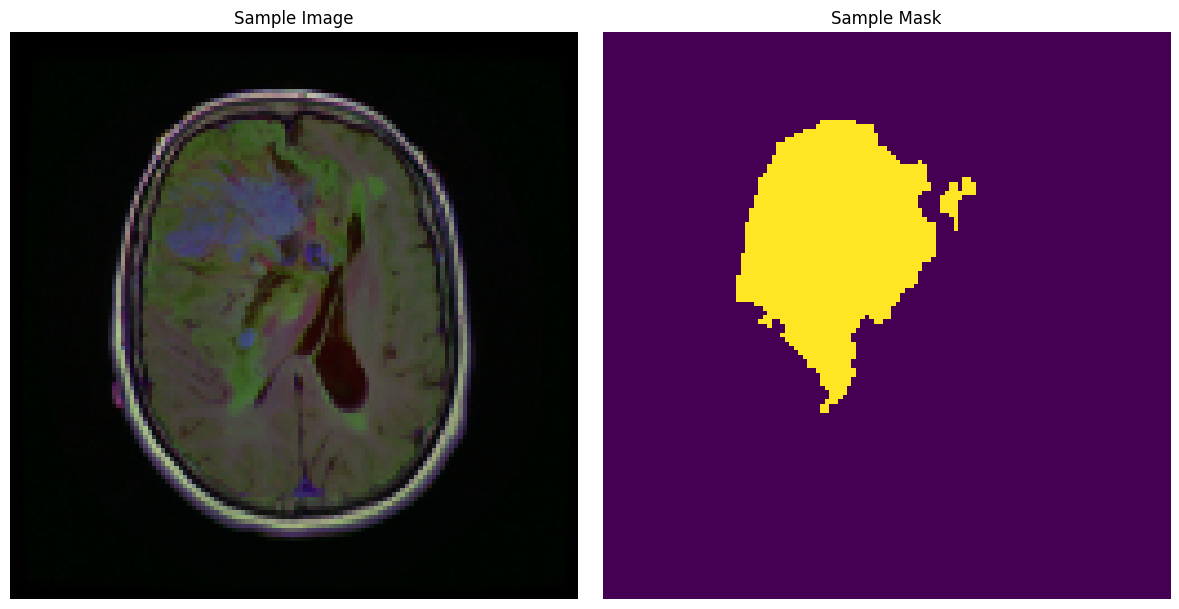

In [58]:
sample_image = sample[0]
sample_mask  = sample[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(sample_image[25], cmap='gray')  
axes[0].set_title('Sample Image')
axes[0].axis('off')  

axes[1].imshow(sample_mask[25], cmap='viridis') 
axes[1].set_title('Sample Mask')
axes[1].axis('off')  

plt.tight_layout() 
plt.show()

In [22]:
def train_valid_generator(self):
        
        dataflow_kwargs = dict(
            target_size     = self.config.params_mask_size,
            batch_size      = self.config.params_batch_size,
            interpolation   = "nearest")
        
        test_gen = ImageDataGenerator()

        if self.config.params_is_augumentation:
            train_gen =ImageDataGenerator(rotation_range      = 30,
                                        width_shift_range   = 0.2,  
                                        height_shift_range  = 0.2, 
                                        shear_range         = 0.2,  
                                        zoom_range          = 0.2,  
                                        horizontal_flip     = True,  
                                        vertical_flip       = True,  
                                        brightness_range    = (0.5, 1.5), 
                                        fill_mode           = 'reflect')
        else:
            train_gen = test_gen()


        self.train_data_generator = train_gen.flow(
            x = self.get_training_config('train').data_for_pipeline[0],
            y = self.get_training_config('train').data_for_pipeline[1],
            **dataflow_kwargs,
            shuffle=False, 
        )

        self.validation_data_generator = test_gen.flow(
            x= self.get_training_config('test').data_for_pipeline[0],
            y= self.get_training_config('test').data_for_pipeline[1],  # Replace with your validation labels as a NumPy array
            **dataflow_kwargs,
            shuffle=False,  
        )
        

    

    

